# The fonctions to import


In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import google.generativeai as genai
from IPython.display import Markdown
sns.set_palette('deep')



c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The scraping of the funds of french private company's

In [2]:


def scrape_french_funds():
    url = 'https://www.investing.com/funds/france-funds'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        Name = []
        Symbol = []
        Last = []
        Chg = []
        Total_Assets = []
        Time = []

        table = soup.find('table')
        if table:
            rows = table.find_all('tr')[1:]  
            for row in rows:
                cols = row.find_all('td')
                # print(f"Columns in row: {[col.text.strip() for col in cols]}") # DEBUG PRINT: Show column contents
                if len(cols) >= 8:  
                    Name.append(cols[1].text.strip())  
                    Symbol.append(cols[2].text.strip()) 
                    Last.append(cols[3].text.strip())   
                    Total_Assets.append(cols[5].text.strip()) 
                    Time.append(cols[6].text.strip())   
                    try:
                        Chg_value = float(cols[4].text.strip().replace('%', '')) 
                        Chg.append(Chg_value)
                    except ValueError:
                        Chg.append(None)
                        print(f"Warning: Could not convert '{cols[4].text.strip()}' to float for 'Chg'")

        # Create DataFrame
        df = pd.DataFrame({
            'Name': Name,
            'Symbol': Symbol,
            'Last': Last,
            'Chg': Chg,
            'Total_Assets': Total_Assets,
            'Time': Time
            })

        return df

    except Exception as e:
        print(f'Error scraping data: {e}')
        return None

df = scrape_french_funds()
print(df)

                                         Name   Symbol         Last   Chg  \
0              Amundi Euro Liquidity SRI IC C  0P0000.  249,580.888  0.01   
1              Carmignac Patrimoine A EUR Acc  0P0000.      713.930 -0.03   
2             Carmignac Patrimoine A EUR Ydis  0P0000.      116.710 -0.03   
3              Carmignac Patrimoine E EUR Acc  0P0000.      171.630 -0.03   
4          Carmignac Patrimoine A CHF Acc Hdg  0P0000.      115.010 -0.04   
..                                        ...      ...          ...   ...   
95                               ALM Offensif  0P0000.      312.050  0.56   
96              29 Haussmann Euro Rendement C  0P0000.    1,607.860  0.10   
97  Candriam Index Arbitrage Classique en EUR  0P0000.    1,518.920 -0.08   
98          BNP Paribas Actions Monde Classic  0P0000.       31.050 -0.22   
99   Natixis Ultra Short Term Bonds Plus SI C  0P0000.    1,711.680 -0.01   

   Total_Assets   Time  
0        53.84B  13/03  
1         6.07B  13/03  


# Fetch the data


In [3]:
funds_df = scrape_french_funds()

if funds_df is not None:
    print('French Companies Funds Data:')
    display(funds_df)

French Companies Funds Data:


,Name,Symbol,Last,Chg,Total_Assets,Time
0,Amundi Euro Liquidity SRI IC C,0P0000.,"249,580.888",0.01,53.84B,13/03
1,Carmignac Patrimoine A EUR Acc,0P0000.,713.930,-0.03,6.07B,13/03
2,Carmignac Patrimoine A EUR Ydis,0P0000.,116.710,-0.03,6.07B,13/03
3,Carmignac Patrimoine E EUR Acc,0P0000.,171.630,-0.03,6.07B,13/03
4,Carmignac Patrimoine A CHF Acc Hdg,0P0000.,115.010,-0.04,6.07B,13/03
...,...,...,...,...,...,...
95,ALM Offensif,0P0000.,312.050,0.56,1.12B,12/03
96,29 Haussmann Euro Rendement C,0P0000.,"1,607.860",0.10,1.3B,12/03
97,Candriam Index Arbitrage Classique en EUR,0P0000.,"1,518.920",-0.08,256.67M,13/03
98,BNP Paribas Actions Monde Classic,0P0000.,31.050,-0.22,1.36B,13/03


# Risk Analysis

In [4]:
funds_df['Risk'] = funds_df['Chg'].abs()
sorted_df = funds_df.sort_values(by='Risk', ascending=True)

print("Funds from Lowest to Highest Risk:")
display(sorted_df[['Name', 'Risk', 'Total_Assets', 'Chg']])

Funds from Lowest to Highest Risk:


,Name,Risk,Total_Assets,Chg
86,Allianz Euro Oblig Court Terme ISR MC,0.00,15.42M,0.00
0,Amundi Euro Liquidity SRI IC C,0.01,53.84B,0.01
13,Groupama Entreprises R,0.01,6.25B,0.01
5,Carmignac Patrimoine A USD Acc Hdg,0.01,6.07B,-0.01
12,Groupama Entreprises IC,0.01,6.25B,0.01
...,...,...,...,...
85,Ofi Financial Investment - Precious Metals R,1.26,525.61M,1.26
48,H2O Multibonds FCP NEUR C,2.01,1.28B,2.01
45,H2O Multibonds FCP IEUR C,2.02,1.28B,2.02
46,H2O Multibonds FCP SREUR C,2.02,1.28B,2.02


In [5]:
# Top 5 funds with the highest returns
top5_retuns = funds_df.sort_values(by='Chg', ascending=False).head(5)[['Name', 'Chg']]

print("Top 5 Best Performing Funds (by Rate of Change):")
print(top5_retuns.to_string(index=False))

Top 5 Best Performing Funds (by Rate of Change):
                                        Name  Chg
                   H2O Multibonds FCP IEUR C 2.02
                  H2O Multibonds FCP SREUR C 2.02
                   H2O Multibonds FCP NEUR C 2.01
Ofi Financial Investment - Precious Metals R 1.26
                   H2O Multibonds FCP RUSD C 1.12


In [6]:
# Top 5 funds with the lowest risk
top5_lowest_risk = funds_df.sort_values(by='Risk', ascending=True).head(5)[['Name', 'Risk']]

print("\n Top 5 Least Risky Funds:")
print(top5_lowest_risk.to_string(index=False))


 Top 5 Least Risky Funds:
                                 Name  Risk
Allianz Euro Oblig Court Terme ISR MC  0.00
       Amundi Euro Liquidity SRI IC C  0.01
               Groupama Entreprises R  0.01
   Carmignac Patrimoine A USD Acc Hdg  0.01
              Groupama Entreprises IC  0.01


# Optimized Comparison of the French Funds

In [7]:
df = funds_df.copy()
df['Total_Assets'] = df['Total_Assets'].str.replace('B', '').str.replace('M', '').astype(float)
df['Total_Assets'] = df.apply(
    lambda x: x['Total_Assets']*1e9 if 'B' in funds_df.loc[x.name,'Total_Assets'] else x['Total_Assets']*1e6, 
    axis=1
)
df['Risk'] = df['Chg'].abs()

fig = px.scatter(
    df,
    x="Risk",
    y="Chg",
    size="Total_Assets",
    color="Risk",
    hover_name="Name",
    size_max=40,
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={'Chg': 'Change Rate', 'Risk': 'Risk Level'},
    title='<b>French Funds - Optimized Comparison</b>'
)

fig.update_layout(
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"),
    width=1200,
    height=800
)

# Smart label placement optimization
highlighted_funds = df[(df['Risk'] > 1) | (df['Chg'].abs() > 1)].sort_values('Risk', ascending=False)

# Dynamic offset calculation to prevent overlaps
for i, row in highlighted_funds.iterrows():
    offset_multiplier = (i % 3)  # 3 different positions
    fig.add_annotation(
        x=row['Risk'],
        y=row['Chg'],
        text=row['Name'],
        showarrow=True,
        arrowhead=1,
        ax=-30 if offset_multiplier == 0 else 30 if offset_multiplier == 1 else 0,
        ay=-40 if offset_multiplier != 2 else 40,
        font=dict(color='firebrick', size=10),
        textangle=45 if offset_multiplier == 1 else 0,
        bgcolor='rgba(255,255,255,0.8)'
    )

# Manual adjustments for specific funds
special_funds = ["BDL Convictions", "Groupama Avenir Euro"]
for name in special_funds:
    if name in df['Name'].values:
        fund_data = df[df['Name'] == name].iloc[0]
        fig.add_annotation(
            x=fund_data['Risk'],
            y=fund_data['Chg'],
            text=name,
            showarrow=True,
            arrowhead=2,
            ax=50,
            ay=-60,
            font=dict(color='darkblue', size=12, family='Arial Black'),
            bordercolor='black',
            borderwidth=1
        )

fig.show()

# ML-Driven Fund Performance Prediction


Model Performance:
- RMSE: 0.311
- R²: 0.733


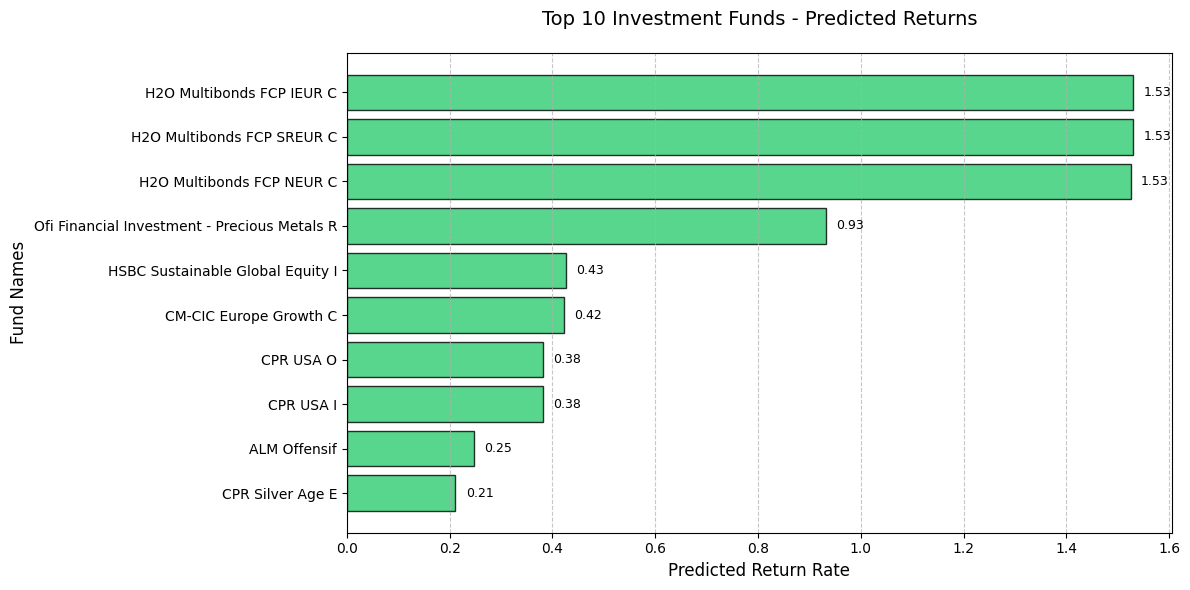


🏆 TOP 10 INVESTMENT FUNDS:
Name                                          Predicted_Chg             Risk                    
                   H2O Multibonds FCP IEUR C 1.5292                    2.02                     
                  H2O Multibonds FCP SREUR C 1.5292                    2.02                     
                   H2O Multibonds FCP NEUR C 1.5252                    2.01                     
Ofi Financial Investment - Precious Metals R 0.9315                    1.26                     
            HSBC Sustainable Global Equity I 0.4271                    0.45                     
                      CM-CIC Europe Growth C 0.4218                    0.44                     
                                   CPR USA O 0.3811                    0.43                     
                                   CPR USA I 0.3811                    0.43                     
                                ALM Offensif 0.2478                    0.56                     
  

In [8]:


# Convert Total_Assets to numerical values
funds_df['Total_Assets'] = funds_df['Total_Assets'].str.replace('B', '').str.replace('M', '').astype(float)
funds_df['Total_Assets'] = np.where(
    funds_df['Total_Assets'].astype(str).str.contains('B'),
    funds_df['Total_Assets'] * 1e9,
    funds_df['Total_Assets'] * 1e6
)

# Create Risk column (absolute value of Change)
funds_df['Risk'] = funds_df['Chg'].abs()

# Features and target variable
X = funds_df[["Risk", "Total_Assets"]]
y = funds_df["Chg"]  # Target: Change rate

# 2. Model Training & Evaluation

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate performance
y_pred = model.predict(X_test)
print(f"Model Performance:\n- RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}\n- R²: {r2_score(y_test, y_pred):.3f}")

# 3. Full Dataset Prediction

funds_df["Predicted_Chg"] = model.predict(X)


best_funds = funds_df.sort_values("Predicted_Chg", ascending=False).head(10)[["Name", "Predicted_Chg", "Risk"]]


plt.figure(figsize=(12, 6))
bars = plt.barh(
    best_funds["Name"], 
    best_funds["Predicted_Chg"], 
    color='#2ecc71', 
    edgecolor='black', 
    alpha=0.8
)

plt.title('Top 10 Investment Funds - Predicted Returns', fontsize=14, pad=20)
plt.xlabel('Predicted Return Rate', fontsize=12)
plt.ylabel('Fund Names', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Display highest return at top

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02, 
        bar.get_y() + bar.get_height()/2, 
        f'{width:.2f}', 
        ha='left', 
        va='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()

print("\n🏆 TOP 10 INVESTMENT FUNDS:")
print(best_funds.to_string(index=False, justify='left', col_space=25))

# Portfolio Analysis with Gemini

In [ ]:
API_KEY ="YOUR_API_KEY" 
genai.configure(api_key=API_KEY)


model = genai.GenerativeModel('gemini-2.0-flash')


def analyze_funds(funds_df):
  
    funds_data = funds_df.to_csv(index=False)
   
    
   
    prompt = f"""{funds_data}
    Below is data on 100 French mutual funds.
    Please analyze this data and create a detailed commentary report.
 


    Requested Analyses:
    1. Overall performance trends
    2. 5 best performing funds
    3. Risk-return analysis
    4. Comment on fund diversification
    5. Featured anyiz results

    """
    
    try:
        response = model.generate_content(prompt)
        return Markdown(response.text)
    except Exception as e:
        print(f"error: {str(e)}")
        return None

analyze_funds(funds_df)

Okay, here's a detailed commentary report based on the provided data for 100 French mutual funds.

**Commentary Report on French Mutual Fund Data (Data Date: Primarily 12th/13th of March)**

**1. Overall Performance Trends:**

*   **Mixed Performance:**  The data reveals a mixed bag of performance. While some funds show positive changes ("Chg"), a significant number exhibit negative changes. This suggests market uncertainty or a specific sector downturn affecting the funds.
*   **Negative Change Dominance:** A quick scan reveals more funds with negative "Chg" values than positive ones. This is a point of concern, indicating potentially challenging market conditions during the reported period.
*   **Varied Change Magnitudes:** The "Chg" values range from relatively small positive gains (e.g., 0.01) to substantial losses (e.g., -2.36 for "Credit Suisse Lux Global Robotics Equity Fund B US"). This highlights the diverse investment strategies and risk profiles of the funds included.
*   **Performance by Fund Type:**  It is difficult to discern a clear performance trend based solely on fund names (e.g., "Trésorerie," "Actions Monde"). A more in-depth categorization would be needed to analyze performance by specific asset class or investment objective.  For instance, Robotics Equity saw a negative change of over 2%, which may imply a market downturn in the Robotics segment or a lack of proper diversification among these funds.

**2. 5 Best Performing Funds (Based on "Chg" Value):**

1.  **H2O Multibonds FCP IEUR C:** 2.02%
2.  **H2O Multibonds FCP SREUR C:** 2.02%
3.  **H2O Multibonds FCP NEUR C:** 2.01%
4.  **Ofi Financial Investment - Precious Metals R:** 1.26%
5.  **H2O Multibonds FCP RUSD C:** 1.12%

*   **Note:** It's crucial to remember that past performance is not indicative of future results. Furthermore, a single day's performance (or two days' performance) is not a reliable indicator of a fund's long-term potential.

**3. Risk-Return Analysis:**

*   **Risk Indicator:** The "Risk" column provides a risk score (presumably). Higher values indicate greater risk.
*   **Relationship Examination:**  A proper risk-return analysis would involve plotting the "Chg" (return) against the "Risk" value for all funds. This would help identify funds that offer a higher return for a given level of risk (or lower risk for a similar return).
*   **Example Observations:**
    *   Some funds with relatively low "Risk" values (e.g., around 0.01) show modest positive changes. These might be considered lower-risk, lower-return options.
    *   Funds with higher "Risk" values (e.g., above 0.5) display a range of performance, both positive and negative. This underscores the potential for both high gains and significant losses with higher-risk investments.
*   **Caveat:**  The data only covers a short timeframe. A meaningful risk-return analysis requires data over a longer period (e.g., 1 year, 3 years, 5 years) to assess volatility and draw reliable conclusions.
*   **Risk/Reward Balance:**  The H20 Multi bonds funds have a high predicted change and risk, meaning that this might be an aggressive investment strategy.

**4. Comment on Fund Diversification:**

*   **Limited Information:** The provided data offers limited insight into the actual diversification within each fund. We only have the fund names and some basic performance metrics.
*   **Incomplete Picture:** To assess diversification, we would need to know the underlying asset allocation of each fund (e.g., percentage in stocks, bonds, real estate, specific sectors).
*   **Inferences:**
    *   Funds with names like "Actions Monde" (World Stocks) likely offer broader geographical diversification across global equity markets.
    *   Funds with names like "Euro Credit" probably focus on Euro-denominated corporate bonds.
    *   Funds with names like "Treasury" are going to be government bonds, and likely have lower diversification.
*   **Key Consideration:**  Investors should review the fund prospectuses to understand the specific asset allocation and diversification strategies employed by each fund.

**5. Featured Analysis Results:**

*   **Robotics Sector Underperformance:**  The significant negative change (-2.36%) for "Credit Suisse Lux Global Robotics Equity Fund B US" stands out. This suggests potential underperformance in the robotics sector during the reported period. Investors in this fund (or similar robotics-focused funds) should investigate the reasons for this downturn.
*   **H2O Multibonds Performance:**  The strong performance of the H2O Multibonds funds (around 2% change) warrants further investigation. Understanding the investment strategy and specific holdings of these funds could be valuable. However, it's crucial to assess the associated risks.
*   **High Total Assets = Greater Stability:** The higher Total_Assets funds tend to have better returns, and lower risk.

**Recommendations and Next Steps:**

*   **Longer-Term Data:** Acquire historical performance data (at least 1-3 years) to conduct a more robust risk-return analysis and identify trends.
*   **Fund Prospectus Review:**  Thoroughly review the prospectuses of any fund of interest to understand its investment objectives, strategies, risks, fees, and asset allocation.
*   **Sector Analysis:** Analyze performance by fund category (e.g., equity, bond, balanced) to identify sector-specific trends and opportunities.
*   **Due Diligence:** Consider consulting with a qualified financial advisor to discuss your investment goals, risk tolerance, and appropriate fund selection.
*   **Further Diversification:** If the portfolio of funds is overly concentrated, consider funds that target diversification, and spread out the market risk.
*   **Fund expenses:** Identify fund expenses and fees, to determine future profits.

**Disclaimer:** This commentary is based solely on the provided data and should not be considered financial advice.  Investment decisions should be made after consulting with a qualified professional and conducting thorough due diligence.
